In [1]:
%matplotlib inline
import lightgbm as lgb
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool
import subprocess
import matplotlib.pyplot as plt
import os
import time
from features import get_features

/Users/hyundai/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Load Data

In [2]:
df_train = pd.read_csv("input/parsed_train.csv", dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv("input/parsed_test.csv", dtype={'fullVisitorId': 'str'})

/Users/hyundai/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Feature Engineering

In [3]:
df_train = get_features(df_train)
df_test = get_features(df_test)

'fea_date_time'  10795.40 ms
'fea_format'  1824.96 ms
'fea_device'  668.51 ms
'fea_totals'  2209.06 ms
'fea_geo_network'  1011.65 ms
'fea_traffic_source'  2869.52 ms
'fea_date_time'  9291.94 ms
'fea_format'  1590.95 ms
'fea_device'  555.53 ms
'fea_totals'  1927.08 ms
'fea_geo_network'  876.39 ms
'fea_traffic_source'  2521.37 ms


### Split X and y, Remove not_used_cols

In [4]:
target_col = 'totals_transactionRevenue'
df_train_y = df_train[target_col].astype(float)
df_train_y.fillna(0, inplace=True)
df_train_y = np.log1p(df_train_y)

In [5]:
not_used_cols = [
    "visitNumber", "date", "fullVisitorId", "sessionId", "visitId",
    "visitStartTime", 'trafficSource_referralPath',
    'trafficSource_campaignCode', target_col,
]
df_train_idx = df_train[['fullVisitorId']]
df_train_X = df_train.drop(not_used_cols, axis=1)

df_test_idx = df_test[['fullVisitorId']]
del_cols = list(set(df_test.columns) & set(not_used_cols))
df_test_X = df_test.drop(del_cols, axis=1)

In [6]:
print(df_train_X.columns)
print(df_test_X.columns)

Index(['channelGrouping', 'socialEngagementType', 'device_browser',
       'device_browserSize', 'device_browserVersion', 'device_deviceCategory',
       'device_flashVersion', 'device_isMobile', 'device_language',
       'device_mobileDeviceBranding', 'device_mobileDeviceInfo',
       'device_mobileDeviceMarketingName', 'device_mobileDeviceModel',
       'device_mobileInputSelector', 'device_operatingSystem',
       'device_operatingSystemVersion', 'device_screenColors',
       'device_screenResolution', 'geoNetwork_city', 'geoNetwork_cityId',
       'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_latitude',
       'geoNetwork_longitude', 'geoNetwork_metro', 'geoNetwork_networkDomain',
       'geoNetwork_networkLocation', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_visits',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficS

### Label Encoding

In [7]:
categorical_feature = list(df_train_X.select_dtypes(exclude=np.number).columns)
# print(categorical_feature)

df_train_X[categorical_feature].fillna('NA_NULL', inplace=True)
df_train_X.fillna(0, inplace=True)

df_test_X[categorical_feature].fillna('NA_NULL', inplace=True)
df_test_X.fillna(0, inplace=True)

for c in categorical_feature:
    st = time.time()
    lbl = LabelEncoder()
    lbl.fit(
        list(df_train_X[c].values.astype('str')) +
        list(df_test_X[c].values.astype('str')))
    df_train_X[c] = lbl.transform(list(df_train_X[c].values.astype('str')))
    df_test_X[c] = lbl.transform(list(df_test_X[c].values.astype('str')))
    print(c, time.time() - st)

/Users/hyundai/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


channelGrouping 5.7473039627075195
socialEngagementType 6.505327224731445
device_browser 8.67323088645935
device_browserSize 7.347347974777222
device_browserVersion 7.28446102142334
device_deviceCategory 4.7660231590271
device_flashVersion 7.129204988479614
device_isMobile 4.677205801010132
device_language 7.4205482006073
device_mobileDeviceBranding 6.94952392578125
device_mobileDeviceInfo 6.936619997024536
device_mobileDeviceMarketingName 6.852864980697632
device_mobileDeviceModel 6.842455863952637
device_mobileInputSelector 6.7945051193237305
device_operatingSystem 5.304574966430664
device_operatingSystemVersion 6.934168815612793
device_screenColors 6.535118103027344
device_screenResolution 6.623642206192017
geoNetwork_city 6.795789957046509
geoNetwork_cityId 6.578384160995483
geoNetwork_continent 4.6865410804748535
geoNetwork_country 5.7132532596588135
geoNetwork_latitude 6.340683937072754
geoNetwork_longitude 6.231293201446533
geoNetwork_metro 8.380459070205688
geoNetwork_networkDo

### Training

In [8]:
df_val_X = df_train_X
df_val_y = df_train_y

feature_name = list(df_train_X.columns)

train = lgb.Dataset(
    df_train_X.values,
    label=df_train_y.values,
    feature_name=feature_name,
    categorical_feature=categorical_feature)

valid = lgb.Dataset(
    df_val_X.values,
    label=df_val_y.values,
    feature_name=feature_name,
    categorical_feature=categorical_feature)

params = {
    "objective": "regression",
    "metric": "rmse",
    "max_depth": 8,
    "min_child_samples": 20,
    "reg_alpha": 1,
    "reg_lambda": 1,
    "num_leaves": 257,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "subsample_freq ": 5,
}

evals_result = {}
train_params = {
    'params': params,
    'train_set': train,
    'valid_sets': [train, valid],
    'valid_names': ['train', 'valid'],
    'evals_result': evals_result,
    'early_stopping_rounds': 100,  #50
    'num_boost_round': 300,  #500
    'verbose_eval': 50,
    'feval': None,
    #     'categorical_feature': 'auto',
}

model = lgb.train(**train_params)

n_estimators = model.best_iteration

/Users/hyundai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1158: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/hyundai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:725: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 1.78177	valid's rmse: 1.78177
[100]	train's rmse: 1.67541	valid's rmse: 1.67541
[150]	train's rmse: 1.61859	valid's rmse: 1.61859
[200]	train's rmse: 1.58507	valid's rmse: 1.58507
[250]	train's rmse: 1.56044	valid's rmse: 1.56044
[300]	train's rmse: 1.54128	valid's rmse: 1.54128
Did not meet early stopping. Best iteration is:
[300]	train's rmse: 1.54128	valid's rmse: 1.54128


### Prediction

In [9]:
y_pred_train = model.predict(df_train_X, num_iteration=model.best_iteration)
y_pred = model.predict(df_test_X, num_iteration=model.best_iteration)

### Report

In [10]:
# Init result configurations
RESULT_PATH = 'results'

time_tag = datetime.datetime.now().strftime('%Y-%m-%dT%H%M%S')
rmse_tag = 'T{0:.3f}_V{0:.3f}_K'.format(model.best_score['train']['rmse'], model.best_score['valid']['rmse'])
result_path = os.path.join(RESULT_PATH, '{}__{}'.format(time_tag, rmse_tag))

os.makedirs(result_path, exist_ok=True)
# Create train set raw result file
df_res = df_train_idx
df_res['y_true'] = df_train_y.values
df_res['y_pred'] = y_pred_train
file_name = 'reg_train_{}.csv'.format(time_tag)
df_res.to_csv(os.path.join(result_path, file_name), index=False)
print('raw_train:', os.path.join(result_path, file_name))

# Create train set raw result file
df_res = df_test_idx
df_res['y_pred'] = y_pred
file_name = 'reg_test_{}.csv'.format(time_tag)
df_res.to_csv(os.path.join(result_path, file_name), index=False)
print('raw_test:', os.path.join(result_path, file_name))

# Create submit file
df_test_idx['PredictedLogRevenue'] = 0
df_test_idx['PredictedLogRevenue'] = y_pred
df_test_idx["PredictedLogRevenue"] = df_test_idx["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
df_test_idx["PredictedLogRevenue"] = df_test_idx["PredictedLogRevenue"].fillna(0.0)
df_submit = df_test_idx[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
df_submit["PredictedLogRevenue"] = np.log1p(df_submit["PredictedLogRevenue"])

file_name = 'aiden_{}.csv.tar.gz'.format(time_tag)
df_submit.to_csv(os.path.join(result_path, file_name), index=False, compression='gzip')
print('submit:', os.path.join(result_path, file_name))

# Write MSG
msg = []
msg.append(str(df_train_X.columns))
# del train_params['evals_result']
# del train_params['valid_sets']
msg.append(str(train_params))

with open(os.path.join(result_path, 'result.log'), 'w') as f:
    f.write('\n'.join(msg))

# Copy notebook to results for history
cmd = """cp -f {notebook_name} {result_path}/{notebook_name}
""".format(**{'notebook_name': 'reg_lgbm.ipynb', 'result_path': result_path})
print(cmd)
subprocess.call(cmd, shell=True)


/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


raw_train: results/2018-09-25T180941__T1.541_V1.541_K/reg_train_2018-09-25T180941.csv


/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


raw_test: results/2018-09-25T180941__T1.541_V1.541_K/reg_test_2018-09-25T180941.csv


/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

submit: results/2018-09-25T180941__T1.541_V1.541_K/aiden_2018-09-25T180941.csv.tar.gz
cp -f reg_lgbm.ipynb results/2018-09-25T180941__T1.541_V1.541_K/reg_lgbm.ipynb



0

In [11]:
df_submit

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.287296
1,0000049363351866189,0.032244
2,0000053049821714864,0.010874
3,0000059488412965267,0.036499
4,0000085840370633780,0.016534
5,0000091131414287111,0.010725
6,0000117255350596610,1.896854
7,0000118334805178127,0.010742
8,0000130646294093000,0.010670
9,0000150005271820273,0.011229


### Feature Importance

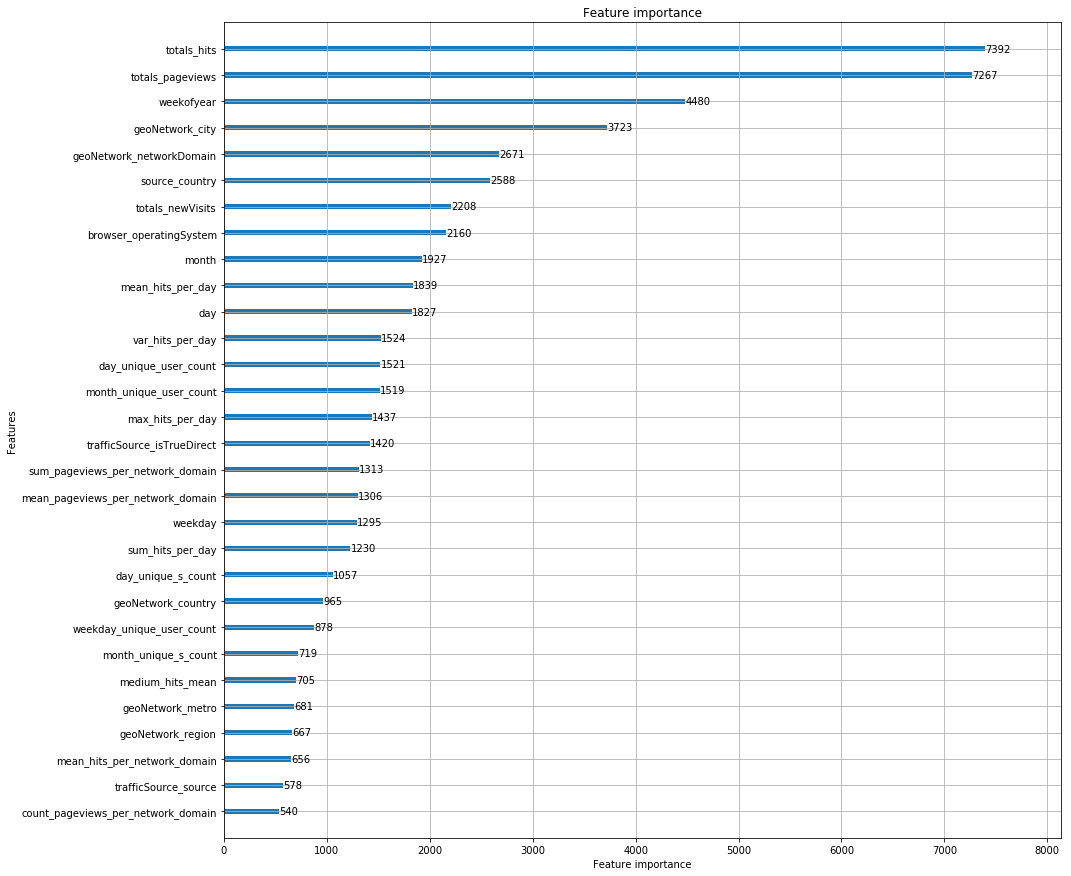

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
lgb.plot_importance(model, ax=ax, max_num_features=30)  
plt.savefig(os.path.join(result_path, 'feature_importance.jpg'))

### to Kaggle with MSG

In [14]:
cmd = """kaggle competitions submit -c ga-customer-revenue-prediction -f {file_path} -m "{msg}"
""".format(**{'file_path': os.path.join(result_path, file_name), 'msg': ','.join(msg)[:500]})
print(cmd)
subprocess.call(cmd, shell=True)

kaggle competitions submit -c ga-customer-revenue-prediction -f results/2018-09-25T180941__T1.541_V1.541_K/aiden_2018-09-25T180941.csv.tar.gz -m "Index(['channelGrouping', 'socialEngagementType', 'device_browser',
       'device_browserSize', 'device_browserVersion', 'device_deviceCategory',
       'device_flashVersion', 'device_isMobile', 'device_language',
       'device_mobileDeviceBranding', 'device_mobileDeviceInfo',
       'device_mobileDeviceMarketingName', 'device_mobileDeviceModel',
       'device_mobileInputSelector', 'device_operatingSystem',
       'device_operatingSystemVersion', 'device_screenColors',
       'device_screenRe"



0